# Project Name: Toxic Comment Classification Challenge
The main aim of this project is to identify and classify toxic online comments

Reference: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

# Exploratory Data Analysis
To understand more about the data

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

import re
from sklearn.model_selection import cross_validate
from sklearn import metrics
import nltk
from nltk.stem import WordNetLemmatizer

#imported these packages for pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import pickle

In [67]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [61]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [62]:
df_train = pd.read_csv("train.csv")
df_test_ = pd.read_csv("test.csv")
df_test_labels = pd.read_csv("test_labels.csv")
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [63]:
print(df_train.shape)
print(df_test_.shape)
print(df_test_labels.shape)
#Note that df_test and df_test labels have same number of records

(159571, 8)
(153164, 2)
(153164, 7)


In [64]:
df_test_merged = pd.merge(df_test_, df_test_labels, on='id', how='inner')
df_test = df_test_merged[~(df_test_merged["toxic"] == -1)].reset_index()
df_test

,index,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
2,11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
3,13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
4,14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
63973,153150,fff8f64043129fa2,":Jerome, I see you never got around to this…! ...",0,0,0,0,0,0
63974,153151,fff9d70fe0722906,==Lucky bastard== \n http://wikimediafoundatio...,0,0,0,0,0,0
63975,153154,fffa8a11c4378854,==shame on you all!!!== \n\n You want to speak...,0,0,0,0,0,0
63976,153155,fffac2a094c8e0e2,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1,0,1,0,1,0


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')


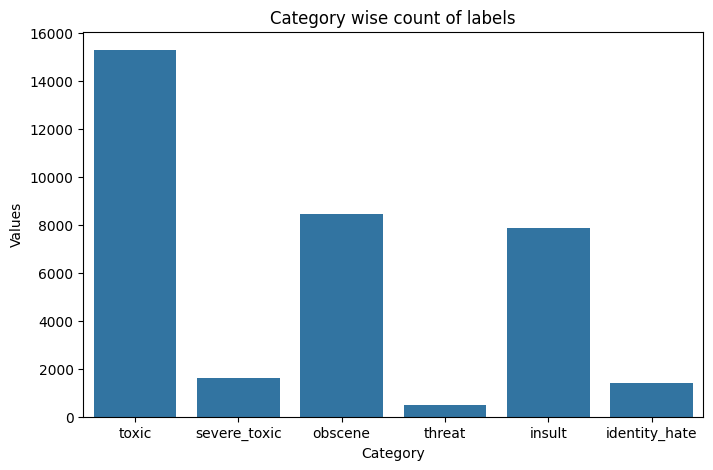

In [65]:
columns = df_train.columns
columns = columns[2:]
print(columns)
col_values = [df_train[df_train[col] == 1].shape[0] for col in columns]

plt.figure(figsize=(8, 5))
sns.barplot(x=columns, y=col_values)
plt.title('Category wise count of labels')
plt.xlabel('Category')
plt.ylabel('Values')
plt.show()


# Implementing Naive Bayes model

In [70]:
import re

def remove_special_characters(text):
    text = re.sub(r'http\S+', ' ', text ) # to remove links
    text = re.sub(r'[^\w\s]', ' ', text) # to remove punctuation, spaces, tabs and line breaks
    text = re.sub(r'\bhttps?://[a-zA-Z0-9-]+(?:\.[a-zA-Z0-9-]+)+\b', ' ', text) # to remove links
    text = re.sub(r'\s+', ' ', text).strip() # to remove extra spaces at the start, middle and end
    text = re.sub(r'\d', ' ', text)  # Removes numbers be it any number of digits
    text= re.sub(r'[\u4e00-\u9fff]+', ' ', text) # to remove chinese
    return text.lower()

def clean_comments(text):
    #tokenizing with given regex
    tokenized_text = nltk.regexp_tokenize(text.lower(), r'(\b[\w]{2,}\b)')

    #lemmatizing each word
    lemmatizer = WordNetLemmatizer()
    cleaned_text = " ".join([lemmatizer.lemmatize(w) for w in tokenized_text])
    return cleaned_text.strip()

df_train['comment_text'] = df_train['comment_text'].apply(remove_special_characters)
df_test['comment_text'] = df_test['comment_text'].apply(remove_special_characters)

df_train['comment_text'] = df_train['comment_text'].apply(clean_comments)
df_test['comment_text'] = df_test['comment_text'].apply(clean_comments)

print(df_train['comment_text'].head(10))

0    explanation why the edits made under my userna...
1    aww he match this background colour seemingly ...
2    hey man really not trying to edit war it just ...
3    more can make any real suggestion on improveme...
4    you sir are my hero any chance you remember wh...
5    congratulation from me well use the tool well ...
6         cocksucker before you piss around on my work
7    your vandalism to the matt shirvington article...
8    sorry if the word nonsense wa offensive to you...
9    alignment on this subject and which are contra...
Name: comment_text, dtype: object


In [76]:
comment_types = df_train.columns[2:]
#'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
for comment_type in comment_types:
  #X_train, X_test, y_train, y_test = train_test_split(, df[agency], test_size=0.10, random_state=42)
  vectorizer = CountVectorizer(binary = True)
  X_train_vectorized = vectorizer.fit_transform(df_train["comment_text"])

  clf = MultinomialNB()
  clf.fit(X_train_vectorized, df_train[comment_type])

  X_test_vectorized = vectorizer.transform(df_test["comment_text"])
  y_pred = clf.predict(X_test_vectorized)
  y_true = df_test[comment_type]

  #scores = metrics.confusion_matrix(y_true, y_pred)

  #printing values
  print(f"Comment_type: {comment_type}")
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  # Print metrics
  print(f"Accuracy: {accuracy:.2f}")
  print(f"Precision: {precision:.2f}")
  print(f"Recall: {recall:.2f}")
  print(f"F1 Score: {f1:.2f}")

Comment_type: toxic
Accuracy: 0.91
Precision: 0.54
Recall: 0.64
F1 Score: 0.58
Comment_type: severe_toxic
Accuracy: 0.98
Precision: 0.08
Recall: 0.20
F1 Score: 0.11
Comment_type: obscene
Accuracy: 0.94
Precision: 0.50
Recall: 0.54
F1 Score: 0.52
Comment_type: threat
Accuracy: 0.99
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Comment_type: insult
Accuracy: 0.94
Precision: 0.45
Recall: 0.47
F1 Score: 0.46
Comment_type: identity_hate
Accuracy: 0.98
Precision: 0.07
Recall: 0.09
F1 Score: 0.08
